In [ ]:
"""


Plott DPR VCUT etc...


"""

"""
Analyse of GPM DPR BB

"""




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wradlib
import wradlib as wrl
from osgeo import osr
import h5py
import glob
from pcc import get_my_cmap
from pcc import get_miub_cmap
from pcc import boxpol_pos
bonn_pos = boxpol_pos()
bx, by = bonn_pos['gkx_ppi'], bonn_pos['gky_ppi']
bonnlat, bonnlon = bonn_pos['lat_ppi'], bonn_pos['lon_ppi']
blat, blon = bonn_pos['lat_ppi'], bonn_pos['lon_ppi']


from pcc import plot_borders
from pcc import plot_radar

% matplotlib inline

print ("  ")

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [2]:
# Ereignisse 2014
#-#ZP = '20140806203538'; pfadnr=1 
#-#ZP = '20140826221000'; pfadnr=1 # 0.82
#-#ZP = '20141007023744' ; pfadnr=0# 0.47
#-#ZP = '20141008094000'; pfadnr=1 # 0.82   
#-#ZP = '20141008094500'; pfadnr=1 # 0.679  
#-#ZP = '20141213141304'; pfadnr=0 # 0.82
#-#ZP = '20141217054500' ; pfadnr=0# 0.47

# Ereignisse 2015
#-#ZP = '20150128171500'; pfadnr=0 #0.28
#-#ZP = '20150128172208'; pfadnr=0#0.321
#-#ZP = '20150225163500'; pfadnr=0 # 0.2
#-#ZP = '20150330233003'; pfadnr=1
#-#ZP = '20150404053404'; pfadnr=0
#-#ZP = '20150626214445'; pfadnr=1
#-#ZP = '20151015203657'; pfadnr=1

#-#ZP = '20151211203853'; pfadnr=1#0.589
#-#ZP = '20151216024501'; pfadnr=0#0.589

# Ereignisse 2016
#-#ZP = '20160209103000'; pfadnr=1 ###PFAD=1#ZP = '20160209103500'; pfadnr=1 # 0.23
#-#ZP = '20160601175950'; pfadnr=1 # 
#-#ZP = '20161109185732'; pfadnr=1 # 
#-#ZP = '20160107124707'; pfadnr=0

# Ereignisse 2017
#-#ZP = '20170211152500'; pfadnr=0 
#-#ZP = '20170211153000'; pfadnr=0 # 0.23

zt = ('20140806','20140826','20141007','20141008','20141008',
'20141213','20141217','20150128','20150225',
'20150330','20150404','20150626','20151015','20151211','20151216',
'20160209','20160601','20161109','20160107','20170211','20170211')
pfadnr = (1,1,0,1,1,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0)

print (len(zt), len(pfadnr))

(21, 21)


In [19]:
#zt = '20141007'; pfadnr = 0
scan  = 'MS'#NS' #or MS

def read_dpr_bb(zt, scan, pfadnr):

    pfad = ('/automount/ags/velibor/gpmdata/dpr/2A.GPM.DPR.V6-20160118.'+zt+'*.HDF5')
    dpr_pfad = sorted(glob.glob(pfad))[pfadnr]

    print dpr_pfad

    # Einlesen
    dpr = h5py.File(dpr_pfad, 'r')
    
    # Position
    dpr_lat=np.array(dpr[scan]['Latitude'])
    dpr_lon=np.array(dpr[scan]['Longitude'])

    # Refelctivity Volumen
    dpr_pp=np.array(dpr[scan]['SLV']['zFactorCorrected'])
    dpr_pp[dpr_pp<0]= np.nan

    # Brightband Attributes
    dpr_bbh=np.array(dpr[scan]['CSF']['heightBB'], dtype=float)
    dpr_bbh[dpr_bbh<0]= np.nan
    qbb = np.array(dpr[scan]['CSF']['qualityBB'])


    #Projection
    proj_stereo = wrl.georef.create_osr("dwd-radolan")
    proj_wgs = osr.SpatialReference()
    proj_wgs.ImportFromEPSG(4326)

    from pcc import boxpol_pos
    bonn_pos = boxpol_pos()
    bx, by = bonn_pos['gkx_ppi'], bonn_pos['gky_ppi']
    bonnlat, bonnlon = bonn_pos['lat_ppi'], bonn_pos['lon_ppi']
    blat, blon = bonn_pos['lat_ppi'], bonn_pos['lon_ppi']

    dpr_lon, dpr_lat = wradlib.georef.reproject(dpr_lon, dpr_lat, projection_target=proj_stereo,
                                                projection_source=proj_wgs)
    bonnlon, bonnlat = wradlib.georef.reproject(bonnlon, bonnlat, projection_target=proj_stereo,
                                                projection_source=proj_wgs)

    # Only BoXPol Region
    lon0, lat0, radius = bonnlon, bonnlat, 100
    r = np.sqrt((dpr_lat - lat0)**2 + (dpr_lon - lon0)**2)
    position = r < radius

    lat = dpr_lat[position]
    lon = dpr_lon[position]

    dpr_pp[np.where(r > radius)]=np.nan

    dpr_bbh[np.where(r > radius)]=np.nan

    #h = np.arange(150,4800,150)
    if scan=='HS':
        hdpr = 1000 * (np.arange(88,0,-1)*0.250)

    else:
        hdpr = 1000 * (np.arange(176,0,-1)*0.125)

    x2 = np.array(dpr_pp.shape[0]*dpr_pp.shape[1]*list(hdpr))
    x1 = dpr_pp.reshape(dpr_pp.shape[0]*dpr_pp.shape[1]*dpr_pp.shape[2])
    
    return x1, x2, dpr_bbh, dpr_pfad, dpr_pp

In [55]:
def plot_cfad(x1,x2,zt, dpr_bbh, dpr_pfad):
    m1 = ~np.isnan(x1) & ~np.isnan(x2)

    x3 = np.array([]); x4 = np.array([]); x5 = np.array([])
    
    dpr_bbh[dpr_bbh<=0]=np.nan
    
    hh = np.array([])
    step =500
    print ("loading")
    for jj in np.arange(0,20000,step):
        #print jj
        hh = np.append(hh,jj)
        x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+step))]))
        x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+step))]))

    plt.figure(figsize=(12,12)) 
    #plt.hexbin(x1[m1], x2[m1],bins=50, cmap='inferno')
    plt.hist2d(x1[m1], x2[m1],bins = 90, cmap='inferno')
    plt.colorbar()
    plt.xlabel('ZH in DBz')
    plt.ylabel('Height in m')
    plt.plot(x3,hh, linewidth=3, label='mean(Z)', color='grey')
    plt.plot(x4,hh, linewidth=3, label='median(Z)', color='green')
    plt.axhline(np.nanmin(dpr_bbh), lw=3, color='grey', label='min(bbh)', linestyle='--')
    plt.axhline(np.nanmax(dpr_bbh), lw=3, color='green', label='max(bbh)', linestyle='--')

    #plt.title(dates)
    plt.ylim(0,6000)
    plt.xlim(15,60)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(color='white')
    plt.figtext(0, 0, dpr_pfad)
    #plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/dpr_cfad_'+zt+'.png')
    #plt.close()
    print ('mean bbh: ',x3)
    print ('median bbh: ',x4)
    print ('dpr mean bbh: ',np.nanmean(dpr_bbh))
    print ('dpr mean bbh: ',np.nanmedian(dpr_bbh))
    print ('dpr unique bbh: ',np.unique(dpr_bbh))

    plt.show()

In [56]:
scan = 'NS'
x1, x2, bbh, dpr_pfad, dpr_pp = read_dpr_bb('20160209', scan, 1)


/automount/ags/velibor/gpmdata/dpr/2A.GPM.DPR.V6-20160118.20160209-S093857-E111130.011074.V04A.HDF5


loading


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Mean of empty slice


('mean bbh: ', array([26.36659813, 25.75868797, 25.62259674, 25.03272438, 23.67759895,
       22.82749939, 22.23613548, 21.50595665, 20.66143036, 18.78097916,
       18.26087761, 16.92278481, 15.56026268, 14.27000046,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan]))
('median bbh: ', array([26.47999954, 25.98500061, 25.85499954, 25.29000092, 23.80999947,
       22.92000008, 22.07500076, 21.39999962, 19.90999985, 18.09000015,
       17.75500107, 16.32999992, 15.73999977, 14.27000046,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         na

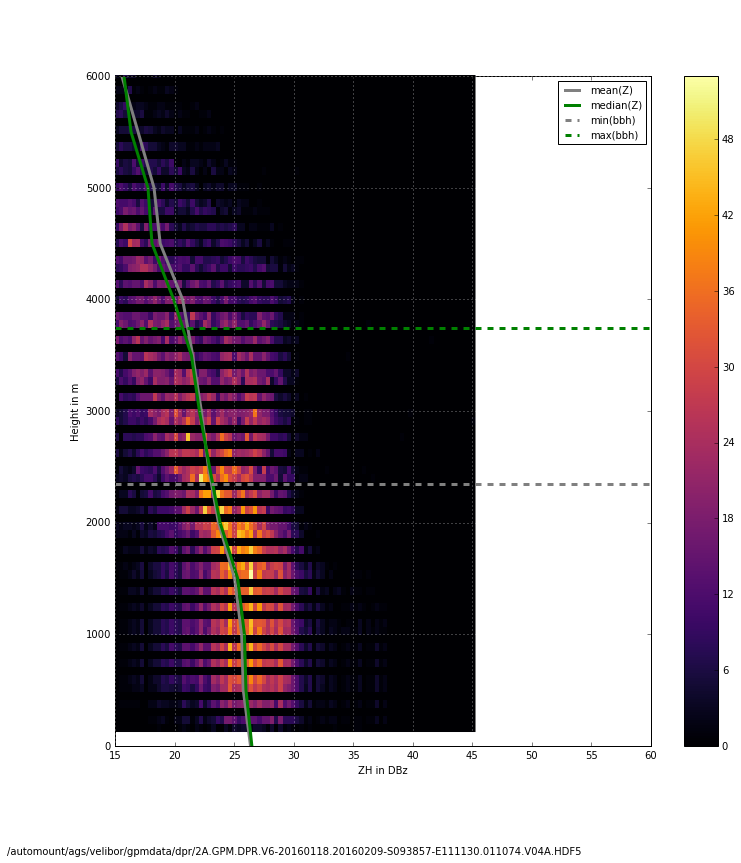

In [57]:
plot_cfad(x1,x2,'20160209',bbh,dpr_pfad)

(array([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2342.93383789, 2356.95544434, 2370.97705078, 2384.99865723,
        2399.02026367, 2413.04187012, 2427.06347656, 2441.08508301,
        2455.10668945, 2469.1282959 , 2483.14990234, 2497.17150879,
        2511.19311523, 2525.21472168, 2539.23632812, 2553.25793457,
        2567.27954102, 2581.30114746, 2595.32275391, 2609.34436035,
        2623.3659668 , 2637.38757324, 2651.40917969, 2665.43078613,
        2679.45239258, 2693.47399902, 2707.49560547, 2721.51721191,
        2735.53881836, 2749.5604248 , 2763.58203125, 2777.6036377 ,
      

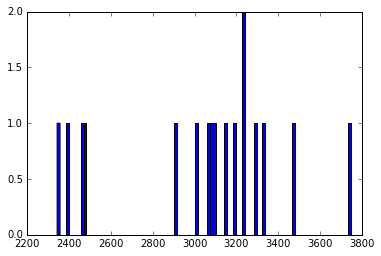

In [ ]:
scan  = 'NS'#NS' #or MS

for jjj in range(len(zt)):
#for jjj in range(10,11):
    print jjj

    x1, x2, bbh,dpr_pfad, dpr_pp =  read_dpr_bb(zt[jjj], scan, pfadnr[jjj])

    plot_cfad(x1,x2,zt[jjj],bbh,dpr_pfad)

In [ ]:
maske1 =  ~np.isnan(x1)
maske2 =  ~np.isnan(dpr_pp)

plt.subplot(1,2,1)
plt.hist(x1[maske1], bins=5)
plt.subplot(1,2,2)
plt.hist(dpr_pp[maske2],bins=5)

In [ ]:
x1.shape, dpr_pp.shape


In [ ]:
7933*49*176

In [ ]:
range(2,3)
